In [47]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
sns.set()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TF version:", tf.__version__)
print("Done loading packages")

TF version: 2.10.0
Done loading packages


In [48]:
import os

def scanData():
    data_count = pd.DataFrame(data={"flower": [], "count": []})
    meta_data_df = pd.DataFrame(data={"image_path": [], "flower_type": []})
    folder_path = "./Flowers_cleaned/"

    subdirectories = next(os.walk(folder_path))[1]

    print(subdirectories)

    for i in subdirectories:
        sub = next(os.walk(folder_path+"/"+i))
        
        new_meta_data = pd.DataFrame(data={"image_path": [ (sub[0] + "/" + j) for j in sub[2]] , "flower_type": i})
        meta_data_df = pd.concat([meta_data_df, new_meta_data], ignore_index=True)
        
        new_data = pd.DataFrame(data={"flower": i, "count": len(sub[2])}, index=[0])      
        data_count = pd.concat([data_count, new_data], ignore_index=True)
        print(i, len(sub[2]), len([ sub[0] + j for j in sub[2]]))

    return data_count, meta_data_df

img_count, meta_data = scanData()
img_count

['Babi', 'Calimerio', 'Chrysanthemum', 'Lisianthus', 'Pingpong']
Babi 931 931
Calimerio 348 348
Chrysanthemum 696 696
Lisianthus 963 963
Pingpong 357 357


,flower,count
0,Babi,931.0
1,Calimerio,348.0
2,Chrysanthemum,696.0
3,Lisianthus,963.0
4,Pingpong,357.0


In [49]:
meta_data

,image_path,flower_type
0,./Flowers_cleaned//Babi/babi_1.jpg,Babi
1,./Flowers_cleaned//Babi/babi_10.jpg,Babi
2,./Flowers_cleaned//Babi/babi_100.jpg,Babi
3,./Flowers_cleaned//Babi/babi_101.jpg,Babi
4,./Flowers_cleaned//Babi/babi_102.jpg,Babi
...,...,...
3290,./Flowers_cleaned//Pingpong/pingpong_95.jpg,Pingpong
3291,./Flowers_cleaned//Pingpong/pingpong_96.jpg,Pingpong
3292,./Flowers_cleaned//Pingpong/pingpong_97.jpg,Pingpong
3293,./Flowers_cleaned//Pingpong/pingpong_98.jpg,Pingpong


<Axes: xlabel='flower', ylabel='count'>

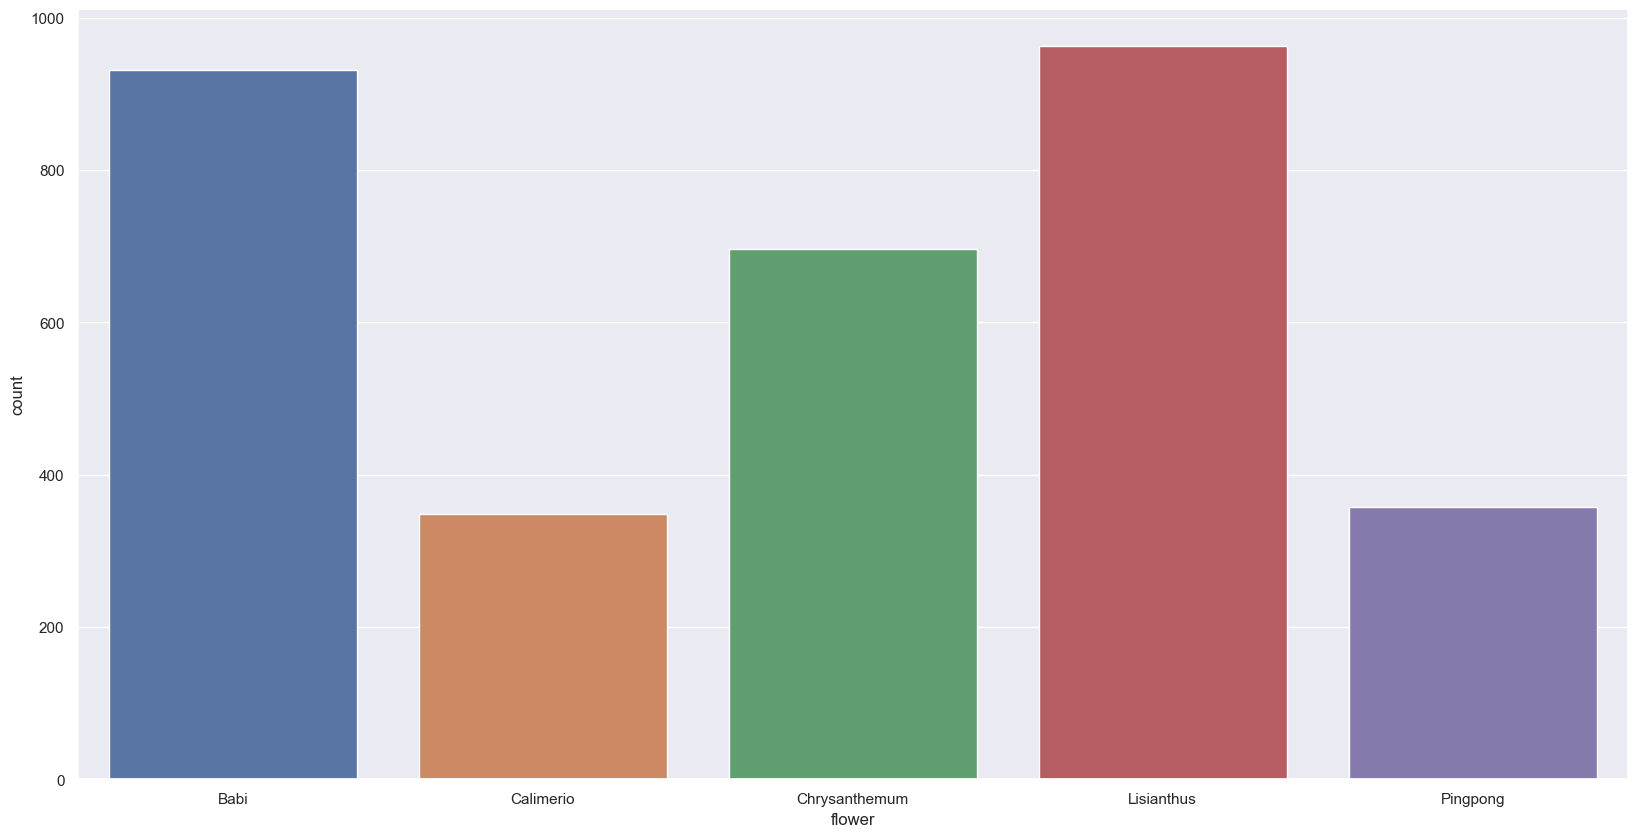

In [50]:
plt.figure(figsize=(20,10))
sns.barplot(data=img_count, x='flower', y='count')

In [51]:
# plt.imshow(new_image = tf.image.per_image_standardization(mpimg.imread(meta_data['image_path'][i])))

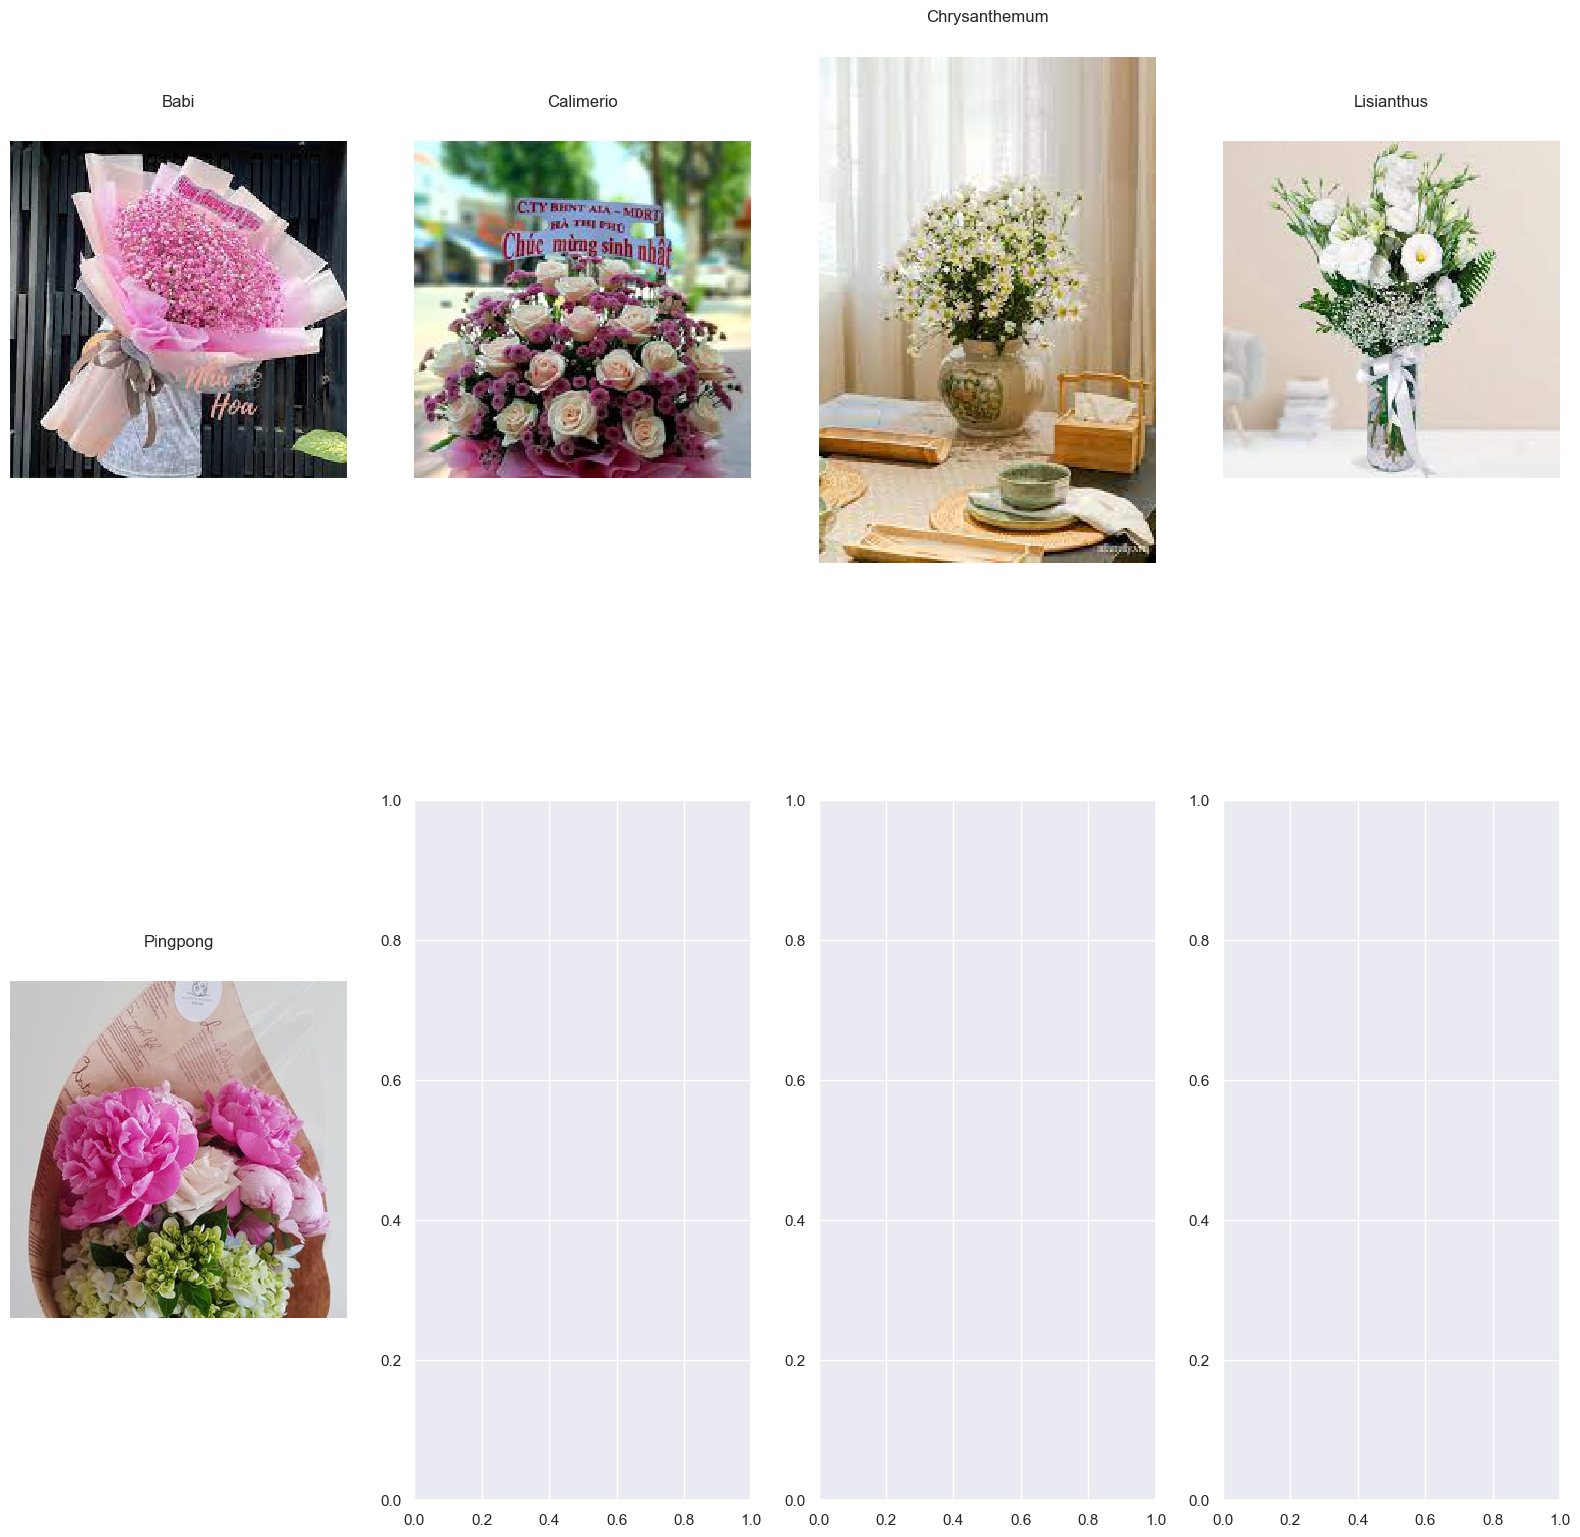

In [52]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
import random
import pathlib

fig, ax = plt.subplots(2, 4, figsize=(20,20), sharex=False)
ax = ax.flatten()

flowers_dir = './Flowers_cleaned/'
flower_labels = sorted(os.listdir(flowers_dir))
flower_labels
flowers_dir_path_object = pathlib.Path(flowers_dir)
for label_number,flower in enumerate(flower_labels):
    
    # get all paths of images inside flower subdirectory
    flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    
    ax[label_number].set_title(flower.capitalize())
    ax[label_number].axis('off')
    flower_img = np.array(load_img(flower_images_paths[0].__str__()))
    ax[label_number].matshow(flower_img)


Train data : 2636, Test Data: 659


<Axes: xlabel='flower_type', ylabel='Count'>

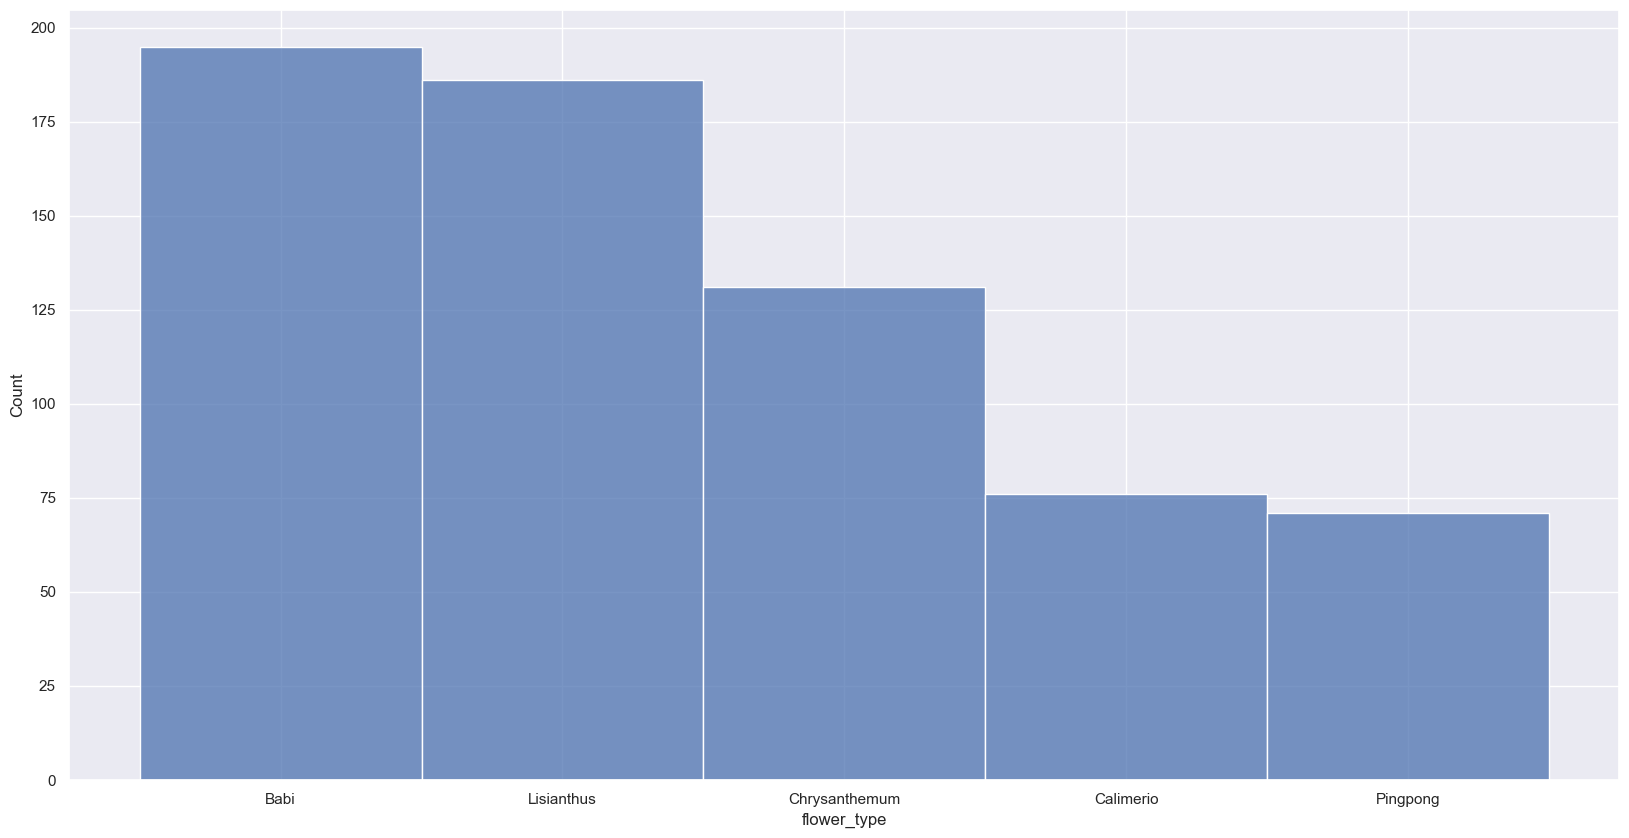

In [85]:
def split_dataset(data):
    TEST_RATIO = 0.2
    train_data, test_data = train_test_split(data, test_size=TEST_RATIO, random_state=100)
    # train_data, val_data = train_test_split(train_data, test_size=TEST_RATIO, random_state=100)

    print("Train data : {}, Test Data: {}".format(
        train_data.shape[0], test_data.shape[0]))
    return train_data, test_data

train_data, test_data = split_dataset(meta_data)

plt.figure(figsize=(20,10))
sns.histplot(data=test_data, x='flower_type')

<Axes: xlabel='flower_type', ylabel='Count'>

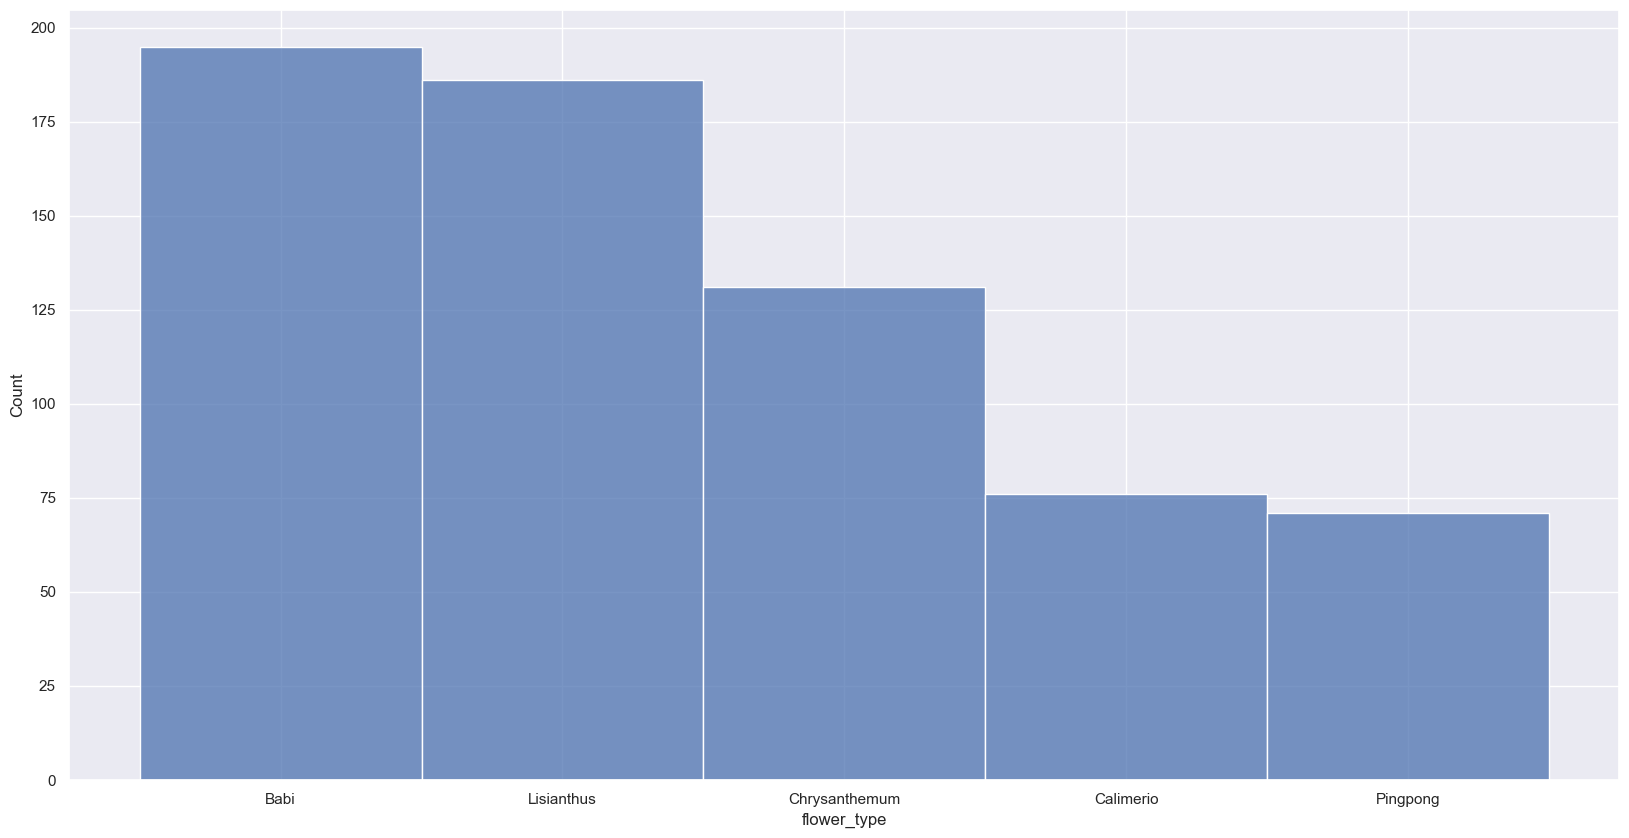

In [75]:
train_data['flower_type'] = train_data['flower_type'].astype('str')
test_data['flower_type'] = test_data['flower_type'].astype('str')



train_datagen = ImageDataGenerator( rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2], # brightness
        rescale=1., data_format='channels_last')
test_datagen = ImageDataGenerator( rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2], # brightness
        rescale=1., data_format='channels_last')

batch_size = 32
# train_datagen.fit(train_data)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col="image_path",
        y_col="flower_type",
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='.',
        x_col="image_path",
        y_col="flower_type",
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical')



Found 2636 validated image filenames belonging to 5 classes.
Found 659 validated image filenames belonging to 5 classes.


In [76]:
train_generator.batch_size

32

In [77]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.axhline(y = max(train_metric), color = 'r', linestyle = '-')
    plt.axhline(y = max(val_metric), color = 'b', linestyle = '-')

    plt.show()

In [78]:
INPUT_DIM = (64,64,3)

HIDDEN_LAYER_1 = 256
HIDDEN_LAYER_2 = 64
HIDDEN_LAYER_3 = 8

OUTPUT_CLASSES = 8

model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_1, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_2, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_3, activation='softmax'),
    
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

In [79]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', y=train_generator.classes, classes=np.unique(train_generator.classes))
class_weights

array([0.71630435, 1.93823529, 0.93309735, 0.67850708, 1.84335664])

In [80]:
class_weights_dict = {}
for k, v in enumerate(class_weights):
    class_weights_dict[k]= v
    

In [81]:

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='mean_squared_logarithmic_error', # tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])


In [82]:
from tensorflow.python.client import device_lib
len(device_lib.list_local_devices()) 

2

In [83]:
!nvidia-smi

Fri May  5 04:58:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 S...  WDDM | 00000000:01:00.0  On |                  N/A |
| 26%   43C    P8                8W / 125W|   3791MiB /  6144MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [84]:
history = model.fit(train_generator, validation_data = test_generator,
                              epochs=20, verbose=2, class_weight=class_weights_dict)


Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_logarithmic_error/SquaredDifference' defined at (most recent call last):
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\trann\AppData\Local\Temp\ipykernel_11004\946698247.py", line 1, in <module>
      history = model.fit(train_generator, validation_data = test_generator,
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\losses.py", line 1725, in mean_squared_logarithmic_error
      tf.math.squared_difference(first_log, second_log), axis=-1
Node: 'mean_squared_logarithmic_error/SquaredDifference'
Detected at node 'mean_squared_logarithmic_error/SquaredDifference' defined at (most recent call last):
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\trann\AppData\Local\Temp\ipykernel_11004\946698247.py", line 1, in <module>
      history = model.fit(train_generator, validation_data = test_generator,
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\trann\anaconda3\envs\image-ml\lib\site-packages\keras\losses.py", line 1725, in mean_squared_logarithmic_error
      tf.math.squared_difference(first_log, second_log), axis=-1
Node: 'mean_squared_logarithmic_error/SquaredDifference'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes: [32,8] vs. [32,5]
	 [[{{node mean_squared_logarithmic_error/SquaredDifference}}]]
	 [[Cast/_17]]
  (1) INVALID_ARGUMENT:  Incompatible shapes: [32,8] vs. [32,5]
	 [[{{node mean_squared_logarithmic_error/SquaredDifference}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8261]

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# cm = sklearn.metrics.multilabel_confusion_matrix(test_generator.classes, model.predict(test_generator))
prediction = model.predict(test_generator)
index_max = prediction.argmax(axis=1)
print(index_max.shape)
# print(prediction[index_max])

In [ ]:
prediction

In [ ]:
prediction.shape

In [ ]:

# fix, ax = plt.subplots(2, 4, sharex=True, figsize=(20,10))
# ax = ax.flatten()
# for i in range(7):
    # sns.histplot(data=new, ax=ax[i])

In [ ]:
cm = tf.math.confusion_matrix(test_generator.classes, index_max, num_classes=8)
# cm = sklearn.metrics.multilabel_confusion_matrix(test_generator.classes, index_max)


print(cm)

In [ ]:
plt.figure(figsize=(20,15))
fx=sns.heatmap(cm, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(train_generator.class_indices)
fx.yaxis.set_ticklabels(train_generator.class_indices)
plt.show()
